In [36]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [37]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

## Case Morocco

In [15]:
scenario = 'Morroco_20201103'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    )

In [24]:
test.open_data()
test.querry_era5()
test.wdir_from_era5()

wdirs = np.arange(-180, 180, 20)

rmses = []
for wdir in wdirs:
    test.wdir_wrt_sensor = wdir
    test.create_dataset()
    test.create_beam_mask()
    test.compute_scatt_eqv_backscatter()
    test.compute_beam_pattern()
    test.compute_leakage_velocity()
    test.compute_leakage_velocity_estimate(speckle_noise=True)
    diff = test.data['V_leakage_pulse_rg_subscene'] - test.data['V_leakage_pulse_rg_subscene_inverted']
    rmse = np.sqrt(np.mean(diff**2))
    rmses.append(rmse)
# test.apply()



Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/0831_0B4E_2DB3_3597_6475_966E_BC59_D53C_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


In [27]:
t = [i.compute() for i in rmses]
rmse = [tt.values*1 for tt in t]


Text(0, 0.5, 'rmse [m/s]')

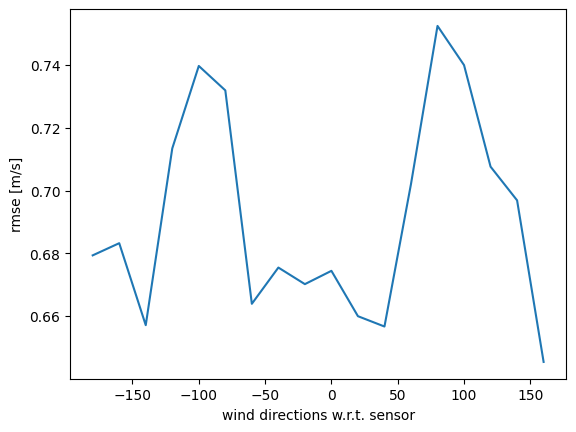

In [34]:
plt.plot(wdirs, rmse)
plt.xlabel('wind directions w.r.t. sensor')
plt.ylabel('rmse [m/s]')

In [35]:
np.std(rmse), np.mean(rmse)

(0.03198009272142549, 0.6916687223646376)

## Case Aghulas (includes land contamination)

In [38]:
scenario = 'Aghulas_20190515'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    )

In [39]:
test.open_data()
test.querry_era5()
test.wdir_from_era5()

wdirs = np.arange(-180, 180, 20)

rmses = []
for wdir in wdirs:
    test.wdir_wrt_sensor = wdir
    test.create_dataset()
    test.create_beam_mask()
    test.compute_scatt_eqv_backscatter()
    test.compute_beam_pattern()
    test.compute_leakage_velocity()
    test.compute_leakage_velocity_estimate(speckle_noise=True)
    diff = test.data['V_leakage_pulse_rg_subscene'] - test.data['V_leakage_pulse_rg_subscene_inverted']
    rmse = np.sqrt(np.mean(diff**2))
    rmse = rmse.compute()
    rmses.append(rmse.values*1)
# test.apply()



Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_92.nc


Text(0, 0.5, 'rmse [m/s]')

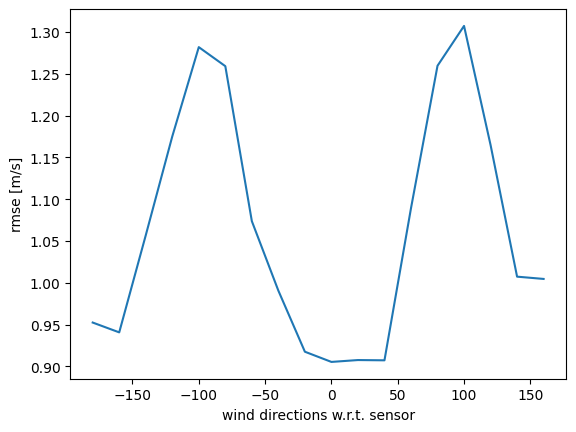

In [40]:
plt.plot(wdirs, rmses)
plt.xlabel('wind directions w.r.t. sensor')
plt.ylabel('rmse [m/s]')

In [42]:
np.std(rmses), np.mean(rmses)

(0.13775093414586917, 1.0668383472495608)

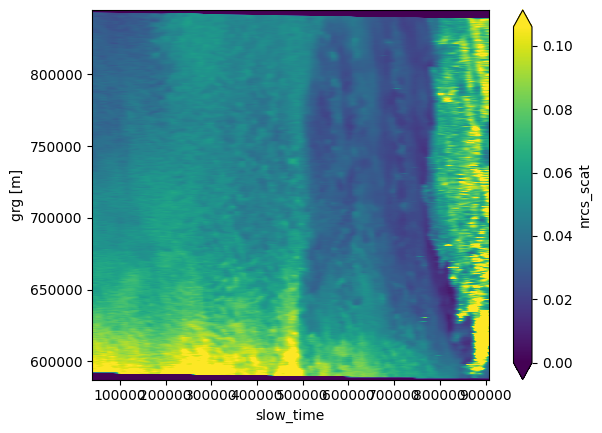

In [48]:
test.data.nrcs_scat.plot(robust = True)